In [ ]:
pip install pvlib pandapower

Optimized generator active power: [[140.          83.20207657  39.00859097  16.77960357   3.40973425]
 [140.          83.59134324  39.26807391  16.97424567   3.5653112 ]
 [140.          83.5916876   39.26887325  16.97246869   3.56534228]
 [140.          83.59195205  39.26859849  16.97309504   3.5653571 ]
 [140.          83.59268361  39.26785878  16.97376927   3.5653023 ]
 [140.          83.59367551  39.26809932  16.97452222   3.56576804]
 [140.          83.59205999  39.26830559  16.97460261   3.56522832]
 [140.          83.59159118  39.26710851  16.97422758   3.56440998]
 [140.          83.59278302  39.26867033  16.97212393   3.56530891]
 [140.          83.59095652  39.26832598  16.97386007   3.5656791 ]
 [140.          83.59073618  39.26771321  16.97516411   3.56584548]
 [140.          83.59239476  39.26671094  16.97393569   3.5650339 ]
 [140.          83.59018986  39.26500403  16.97308141   3.56400898]
 [140.          83.58997883  39.26387453  16.9730743    3.56474875]
 [140.        

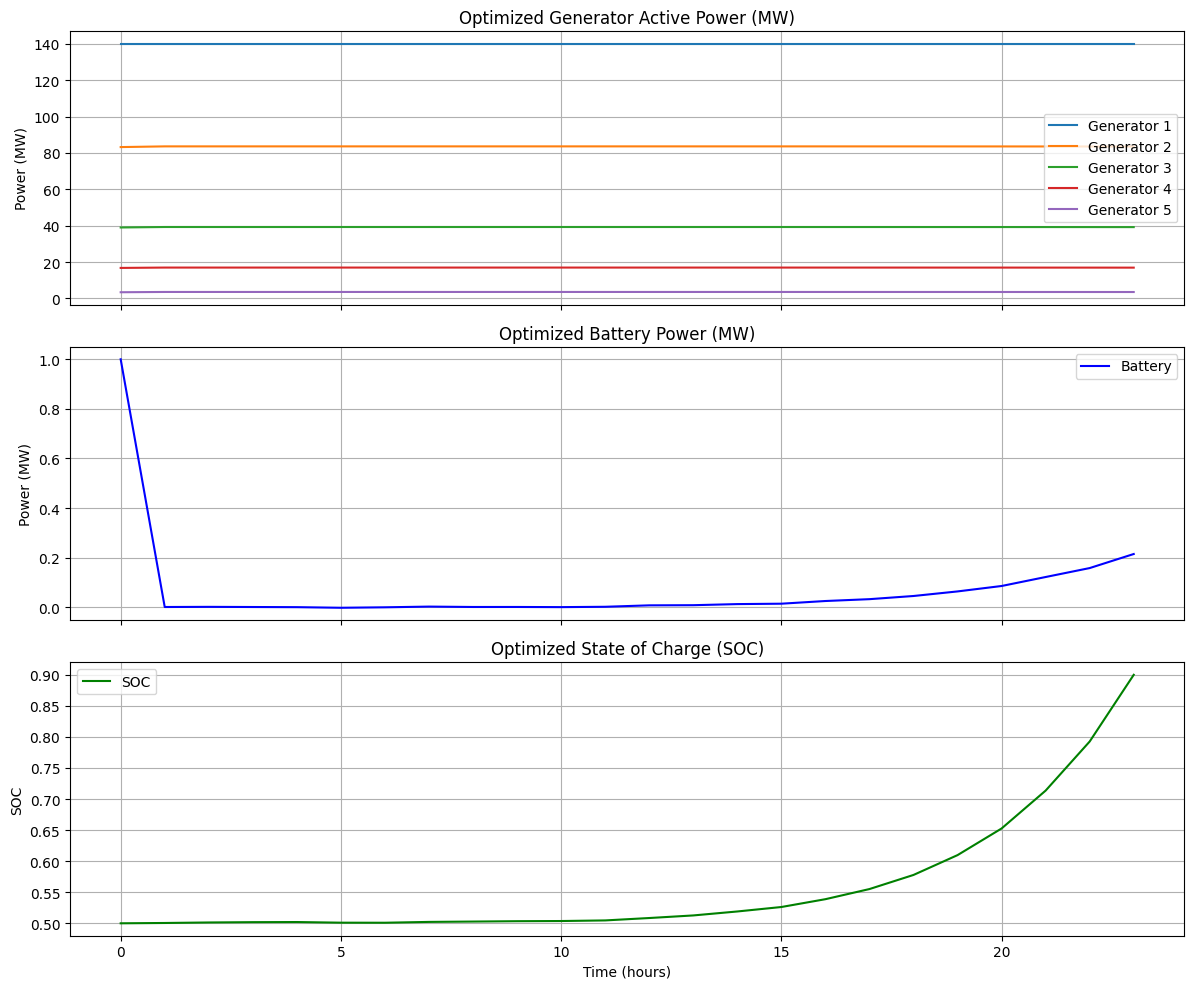

In [9]:
import pandas as pd
import pvlib
import pandapower as pp
import pandapower.networks as pn
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


net = pn.case_ieee30()

net.gen['a'] = [0.01, 0.02, 0.03, 0.04, 0.05]  # cost coefficient a for each generator
net.gen['b'] = [1, 2, 3, 4, 5]  # cost coefficient b for each generator
net.gen['c'] = [100, 200, 300, 400, 500]  # cost coefficient c for each generator

# Define the weights for the power loss and generation cost
w1 = 0.5  # weight for power loss
w2 = 0.5  # weight for generation cost

# Define Battery
battery_bus = 10
battery_power_mw = 1  # Maximum power in MW
battery_capacity_mwh = 2  # Maximum energy capacity in MWh
pp.create_storage(net, battery_bus, p_mw=0, max_e_mwh=battery_capacity_mwh, max_p_mw=battery_power_mw, name="Battery")

# Define time steps
n_time_steps = 24 # For example, 24 hours

# Define constraints for SOC
SOC_min = 0.1
SOC_max = 0.9

# Initial SOC
initial_SOC = 0.5

# Time step duration in hours
dt = 1
# Define location (latitude and longitude)
location = pvlib.location.Location(latitude=40, longitude=-80)

# Define a time range (for example, 24 hours)
times = pd.date_range(start='2023-08-04', end='2023-08-05', freq='1H')

# Calculate clear-sky GHI and transpose to plane of array
solar_position = location.get_solarposition(times)
clearsky = location.get_clearsky(times, solar_position=solar_position)
dni_extra = pvlib.irradiance.get_extra_radiation(times)  # Calculate extraterrestrial radiation
poa = pvlib.irradiance.get_total_irradiance(
    30, 180, solar_position['apparent_zenith'], solar_position['azimuth'],
    clearsky['dni'], clearsky['ghi'], clearsky['dhi'], dni_extra=dni_extra, model='haydavies'
)

# Define PV system characteristics and ModelChain

inverter_parameters = {
    'paco': 1000,
    'pdc0': 1000,  # Adding pdc0 to inverter parameters
    'eta_inv_nom': 0.96,  # Example of nominal inverter efficiency
}
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
# Continue to define the PVSystem with the updated inverter_parameters
system = pvlib.pvsystem.PVSystem(surface_tilt=30, surface_azimuth=180,
                                 module_parameters={'pdc0': 1000, 'gamma_pdc': -0.004},
                                 inverter_parameters=inverter_parameters,
                                 temperature_model_parameters=temperature_model_parameters)

mc = pvlib.modelchain.ModelChain(system, location, ac_model='pvwatts',
                                 aoi_model='no_loss', spectral_model='no_loss')





# Run model
weather = pd.DataFrame({'temp_air': 25, 'wind_speed': 5}, index=times)
weather['dni'] = poa['poa_direct']
weather['ghi'] = poa['poa_global']
weather['dhi'] = poa['poa_diffuse']
mc.run_model(weather)

# Solar power output in MW


solar_bus = 5
solar_power_mw = mc.results.ac.iloc[0] / 1e6
pp.create_sgen(net, solar_bus, p_mw=solar_power_mw, q_mvar=0, name="Solar Panel")



def objective(x):
    total_cost = 0
    total_loss = 0
    for t in range(n_time_steps):
        p_gen = x[t*len(net.gen):(t+1)*len(net.gen)]
        p_batt = x[n_time_steps*len(net.gen) + t]
        net.gen['p_mw'] = p_gen
        net.storage['p_mw'] = p_batt

        # Run a power flow
        pp.runpp(net)

        # Compute the cost for each generator and sum them up
        cost = np.sum(net.gen['a'] * p_gen**2 + net.gen['b'] * p_gen + net.gen['c'])
        total_cost += cost

        # Compute the power loss in each line and sum them up
        loss = np.sum(net.res_line['pl_mw'])
        total_loss += loss

    # Compute the combined objective function
    combined_objective = w1 * total_loss + w2 * total_cost
    return combined_objective, total_loss, total_cost





# Initial guess and bounds
n_gen = len(net.gen)
x0 = np.concatenate([net.gen['p_mw'].values] * n_time_steps)  # Repeat generator powers
x0 = np.append(x0, np.zeros(n_time_steps))  # Add battery powers
x0 = np.append(x0, np.full(n_time_steps, initial_SOC)) # Add SOC

bounds_gen = [(0, p_max) for p_max in net.gen['max_p_mw']] * n_time_steps
bounds_batt = [(-battery_power_mw, battery_power_mw)] * n_time_steps
bounds_SOC = [(SOC_min, SOC_max)] * n_time_steps
bounds = bounds_gen + bounds_batt + bounds_SOC

def constraints(x):
    cons = []
    for t in range(n_time_steps):
        p_gen = x[t * n_gen:(t + 1) * n_gen]
        p_batt = x[n_time_steps * n_gen + t]
        SOC = x[n_time_steps * n_gen + n_time_steps + t]

        # Constraint that total generation plus battery discharge must equal total load plus solar panel power
        load_constraint = sum(p_gen) + p_batt - sum(net.load['p_mw']) - solar_power_mw
        cons.append(load_constraint)

        # Constraint for SOC dynamics
        # Constraint for SOC dynamics
        if t == 0:
            SOC_constraint = SOC - initial_SOC  # Setting SOC at t = 0 to initial_SOC
        else:
            previous_SOC = x[n_time_steps * n_gen + n_time_steps + t - 1]
            SOC_constraint = SOC - (previous_SOC + p_batt * dt / battery_capacity_mwh)
        cons.append(SOC_constraint)

    return np.array(cons)


# Constraints dictionary
cons_dict = {'type': 'eq', 'fun': constraints}

# Call the SciPy optimizer
solution = minimize(lambda x: objective(x)[0], x0, method='SLSQP', bounds=bounds, constraints=cons_dict)


# Process results
if solution.success:
    optimized_p_gen = solution.x[:n_time_steps*n_gen].reshape((n_time_steps, n_gen))
    optimized_p_batt = solution.x[n_time_steps*n_gen:n_time_steps*n_gen+n_time_steps]
    optimized_SOC = solution.x[n_time_steps*n_gen+n_time_steps:]

    print("Optimized generator active power:", optimized_p_gen)
    print("Optimized battery power:", optimized_p_batt)
    print("Optimized SOC:", optimized_SOC)
else:
    print("Optimization did not converge:", solution.message)


# Process results
if solution.success:
    ...
    combined_objective, total_loss, total_cost = objective(solution.x)
    print("Combined objective function:", combined_objective)
    print("Total power loss:", total_loss)
    print("Total generation cost:", total_cost)





# Create a figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plotting Optimized Generator Active Power
for i in range(n_gen):
    ax1.plot(optimized_p_gen[:, i], label=f"Generator {i+1}")
ax1.set_title('Optimized Generator Active Power (MW)')
ax1.set_ylabel('Power (MW)')
ax1.legend()
ax1.grid(True)

# Plotting Optimized Battery Power
ax2.plot(optimized_p_batt, label="Battery", color='blue')
ax2.set_title('Optimized Battery Power (MW)')
ax2.set_ylabel('Power (MW)')
ax2.legend()
ax2.grid(True)

# Plotting Optimized SOC
ax3.plot(optimized_SOC, label="SOC", color='green')
ax3.set_title('Optimized State of Charge (SOC)')
ax3.set_xlabel('Time (hours)')
ax3.set_ylabel('SOC')
ax3.legend()
ax3.grid(True)

# Show the plot
plt.tight_layout()
plt.show()